<div style="text-align: center">
<img src=http://hrudnick.sitios.ing.uc.cl/alumno17/gnl/UClogo.png alt="LogoUc" width="150" height="100">

<div style="text-align: center;font-size:30px"> $\color{steelblue}{\underline{\text{Minería de Datos}}}$
<div style="text-align: center;font-size:23px"> $\color{steelblue}{\underline{\text{- Proyecto Final -}}}$

<div style="text-align: right;font-size:16px"> $\color{steelblue}{\underline{\text{Data Science Team}}}$ </div>
<div style="text-align: right;font-size:14px"> Boris Carbonell  - <a href = "mailto: b.carbonell@uc.cl">b.carbonell@uc.cl</a> </div>
<div style="text-align: right;font-size:14px"> Magdalena Herrera  - <a href = "mailto: Maherrera12@uc.cl">Maherrera12@uc.cl</a> </div>
<div style="text-align: right;font-size:14px"> Nibaldo Pino Araya  - <a href = "mailto: n.pino@uc.cl">n.pino@uc.cl</a> </div>


In [1]:
# Librerias
import category_encoders as ce
import matplotlib.pyplot as plt
import missingno as msng
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

import pickle

import FuncionesAncilares as fx

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Lectura de datos de entrenamiento

In [2]:
data_train = pd.read_csv('train.csv').drop(columns = ['id'])
datos = data_train.copy()

display(data_train.head())
display(data_train.shape)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


(600000, 24)

# Análisis Exploratorio (EDA)
### Variables en análisis

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   582106 non-null  float64
 1   bin_1   581997 non-null  float64
 2   bin_2   582070 non-null  float64
 3   bin_3   581986 non-null  object 
 4   bin_4   581953 non-null  object 
 5   nom_0   581748 non-null  object 
 6   nom_1   581844 non-null  object 
 7   nom_2   581965 non-null  object 
 8   nom_3   581879 non-null  object 
 9   nom_4   581965 non-null  object 
 10  nom_5   582222 non-null  object 
 11  nom_6   581869 non-null  object 
 12  nom_7   581997 non-null  object 
 13  nom_8   582245 non-null  object 
 14  nom_9   581927 non-null  object 
 15  ord_0   581712 non-null  float64
 16  ord_1   581959 non-null  object 
 17  ord_2   581925 non-null  object 
 18  ord_3   582084 non-null  object 
 19  ord_4   582070 non-null  object 
 20  ord_5   582287 non-null  object 
 21  day     58

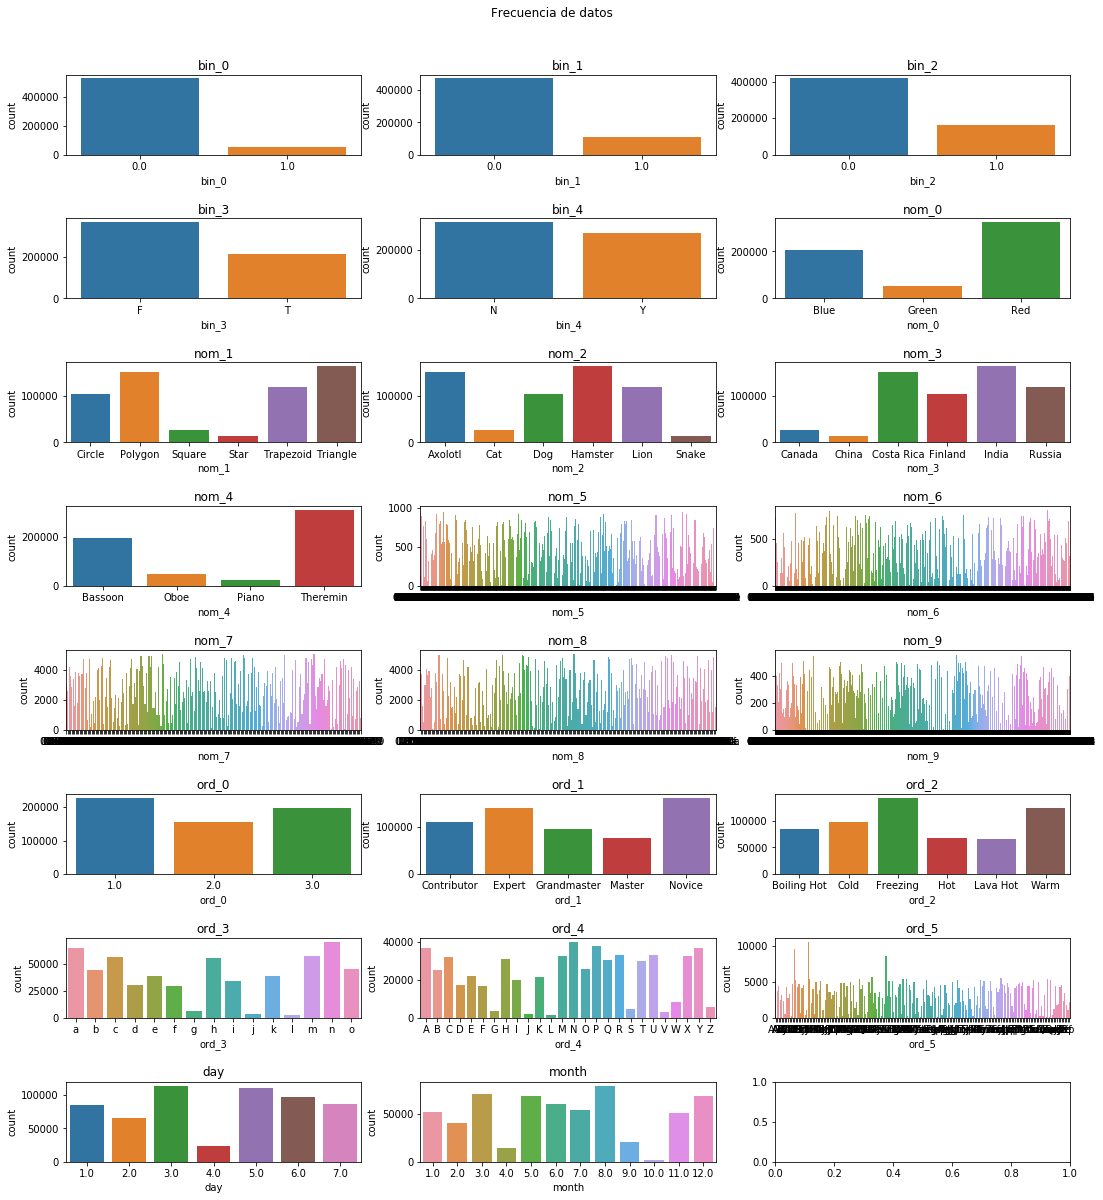

In [4]:
features = data_train.columns.drop('target')
fx.plot_features(data_train, columns = features)

### Selección de Variables

- Se observa que existen variables nominales y ordinales las cuales dificilmente podemos obtener algun tipo de
estadístico que nos indique información relevante de ellas. Esto es, ya que parecen ser códigos alfanuméricos pero no
se tiene una explicación de su composición.
- Estas variables son `nom_[6-9]`.
- Además de esto, la variable `ord_5` presenta 190 clases o categorias las cuales no tienen un orden aparente el cual
podamos reclasificar como se hará más adelante.

In [5]:
#Eliminamos las variables
cols_drop = ['nom_5','nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_5']
fx.drop_columns(data_train, cols_drop)

data_train.columns
print(data_train.shape)

(600000, 18)


### Imputación de Datos Faltantes

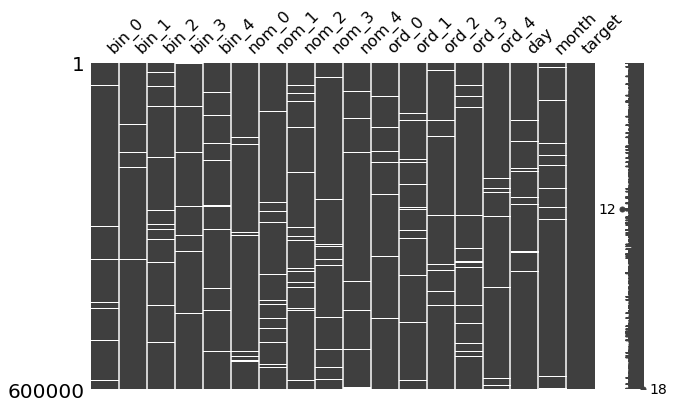

In [6]:
# Matriz de datos perdidos
msng.matrix(data_train, figsize = (10,6));

La matriz de datos perdidos evidencia la presencia de datos perdidos en cada una de las columnas
que componen el data set de entrenamiento. Si estas no superan el 5% serán imputadas por el valor mas frecuenta
para cada columna.

In [7]:
data_train.isnull().sum()/data_train.shape[0]*100

bin_0     2.982333
bin_1     3.000500
bin_2     2.988333
bin_3     3.002333
bin_4     3.007833
nom_0     3.042000
nom_1     3.026000
nom_2     3.005833
nom_3     3.020167
nom_4     3.005833
ord_0     3.048000
ord_1     3.006833
ord_2     3.012500
ord_3     2.986000
ord_4     2.988333
day       2.992000
month     2.998000
target    0.000000
dtype: float64

__OBSERVACIÓN:__
Como el porcentaje de valores faltantes no supera el 3%, usaremos la moda para imputar los datos faltantes.

In [8]:
fx.null_replace(data_train)

## Análisis Univariado
### Análisis de Variable Objetivo: `target`


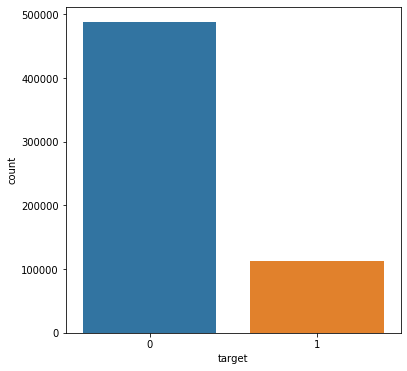

In [9]:
plt.figure(figsize=(6,6))
ax = sns.countplot(datos.target)

__Observacion:__
Se aprecia un evidente desbalance en la proporcion de los datos con respecto a las clases que constituyen la variable
objetivo `target`. Este problema sera abordado posteriormente.

## Análisis de Variables Caracteristicas
### Recodificación de Variables Binarias

In [10]:
# Recodificación de Variables Binarias
fx.binary_var(data_train)
data_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,ord_0,ord_1,ord_2,ord_3,ord_4,day,month,target
0,0,0,0,0,0,Red,Trapezoid,Hamster,Russia,Bassoon,3,Contributor,Hot,c,U,6,3,0
1,1,1,0,0,1,Red,Star,Axolotl,India,Theremin,3,Grandmaster,Warm,e,X,7,7,0
2,0,1,0,0,0,Red,Triangle,Hamster,Canada,Bassoon,3,Novice,Freezing,n,P,5,9,0
3,0,0,0,0,0,Red,Circle,Hamster,Finland,Theremin,1,Novice,Lava Hot,a,C,3,3,0
4,0,0,0,1,0,Red,Triangle,Hamster,Costa Rica,Theremin,3,Grandmaster,Cold,h,C,5,12,0


__Observacion:__
Las variables `bin_[0-4]` fueron recodificadas, en 0 y 1, considerando que algunas de estas tenian el formato de Y-N o T-F.

### Recodificación de Variables Categóricas

#### Variables Nominales

In [11]:
data_train = fx.nominal_encoder(data_train)
data_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,ord_0,ord_1,ord_2,ord_3,ord_4,day,month,target
0,0,0,0,0,0,1,1,1,1,1,3,Contributor,Hot,c,U,6,3,0
1,1,1,0,0,1,1,2,2,2,2,3,Grandmaster,Warm,e,X,7,7,0
2,0,1,0,0,0,1,3,1,3,1,3,Novice,Freezing,n,P,5,9,0
3,0,0,0,0,0,1,4,1,4,2,1,Novice,Lava Hot,a,C,3,3,0
4,0,0,0,1,0,1,3,1,5,2,3,Grandmaster,Cold,h,C,5,12,0


__Observacion:__
Todas las variables ordinales, sin un orden apararente, `nom_[0-4]`, fueron recodificadas a su forma númerica, para análisis posteriores.

#### Variables Ordinales

In [12]:
data_train = fx.ordinal_encoder(data_train)
data_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,ord_0,ord_1,ord_2,ord_3,ord_4,day,month,target
0,0,0,0,0,0,1,1,1,1,1,3,2,4,3,21,6,3,0
1,1,1,0,0,1,1,2,2,2,2,3,5,3,5,24,7,7,0
2,0,1,0,0,0,1,3,1,3,1,3,1,1,14,16,5,9,0
3,0,0,0,0,0,1,4,1,4,2,1,1,6,1,3,3,3,0
4,0,0,0,1,0,1,3,1,5,2,3,5,2,8,3,5,12,0


__Observacion:__
Manteniendo el orden de origen, las variables ordinales `ord_[0-4]` fueron recodificadas a su forma numerica, para posteriores analisis.

## Tratamiento de Desbalance de los datos de entrenamiento

In [13]:
data_train.target.value_counts('%')


0    0.812795
1    0.187205
Name: target, dtype: float64

__Observaciones:__
Como se puede apreciar, la data se encuentra evidentemente desbalanceada. Por esta razón se aplicará una tecnica
de submuestreo aleatorio (Random Undersamplig) para corregir este desbalance.

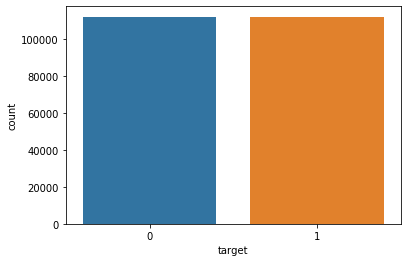

In [14]:
# Aplicando undersampling
data_train = fx.subsampling(data_train)
sns.countplot(data_train.target);

## One Hot Encoder

Este proceso creará una subvariable para cada clase de las variables categoricas, nominales u ordinales, presentes en el dataset.

In [15]:
cols_dum = ['nom_0', 'nom_1', 'nom_2','nom_3', 'nom_4', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4']
data_train = fx.cols_dummies_transform(data_train, cols_dum)
display(data_train.head())
display(data_train.shape)


,bin_0,bin_1,bin_2,bin_3,bin_4,day,month,target,nom_0_1.0,nom_0_2.0,...,ord_4_18.0,ord_4_19.0,ord_4_20.0,ord_4_21.0,ord_4_22.0,ord_4_23.0,ord_4_24.0,ord_4_25.0,ord_4_26.0,ord_4_nan
128893,0,1,1,1,0,3,3,0,1,0,...,0,0,0,0,1,0,0,0,0,0
363720,0,0,0,0,0,5,8,0,1,0,...,0,0,0,0,0,0,1,0,0,0
267683,0,0,0,0,0,1,8,0,1,0,...,0,0,1,0,0,0,0,0,0,0
465055,0,0,0,0,1,6,12,1,1,0,...,0,0,0,0,0,0,0,0,0,0
363377,0,0,0,0,0,3,6,0,1,0,...,0,0,0,0,0,0,0,0,0,0


(224646, 94)

## Lectura y Procesamiento Datos de Test

In [16]:
# Lectura de datos de test
data_test = pd.read_csv('test.csv').drop(columns = ['id'])
display(data_test.head())
display(data_test.shape)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0.0,0.0,0.0,F,Y,Blue,Polygon,Axolotl,Finland,Piano,...,ca9ad1d4b,fced9e114,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0
1,0.0,0.0,0.0,F,Y,Red,Circle,Lion,Russia,Bassoon,...,060a21580,7ca8775da,1.0,Novice,Cold,n,N,NaN,2.0,8.0
2,0.0,0.0,0.0,F,Y,Blue,Circle,Axolotl,Russia,Theremin,...,165e81a00,5940334c9,1.0,Expert,Warm,i,N,DN,2.0,6.0
3,1.0,0.0,0.0,F,N,Red,Polygon,Axolotl,Costa Rica,Bassoon,...,77d41330d,6fbdeefc8,1.0,Expert,Hot,m,B,AG,1.0,6.0
4,0.0,0.0,1.0,F,Y,Red,Circle,NaN,Finland,Theremin,...,2218d9dfe,2a27c8fde,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0


(400000, 23)

In [17]:
#Procesamiento de datos de test
data_test = fx.data_processing(data_test)
display(data_test.head())
display(data_test.shape)

,bin_0,bin_1,bin_2,bin_3,bin_4,day,month,nom_0_1.0,nom_0_2.0,nom_0_3.0,...,ord_4_18.0,ord_4_19.0,ord_4_20.0,ord_4_21.0,ord_4_22.0,ord_4_23.0,ord_4_24.0,ord_4_25.0,ord_4_26.0,ord_4_nan
0,0,0,0,0,1,3,9,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,2,8,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,2,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,6,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,3,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0


(400000, 93)

# Modelamiento
### Data Split

In [18]:
X_train = data_train.drop(columns = ['target'])
y_train = data_train.target
X_test = data_test

### Entrenamiento de Modelos

Se han entrenado 3 modelos de clasificación:
- `LogisticRegression()`
- `tree_params()`
- `gradient_params()`

Los hiperparametros de estos modelos han sido optimizados bajo la busqueda de grilla, en general, con 5 validaciones
cuzadas. Posteriormente, todos los analisis que se llevan a cabo se relaizan bajo los mejores hiperparametros reportados
en dicha busqueda.

En la libreria del proyecto `FuncionesAncilares.py` la función `training_models_cv(X_train, y_train)` entrena
los modelos de forma automatizada. La optimización es exigente en terminos de rendimiento computacional, estos fueron
entrenados y exportados en los archivos con extensión `.sav`, los que se utilizan en para los analisis posteriores.

De todos modos, se explicita el prodemiento de entrenamiento y ajuste para cada uno de los modelos.

__Entrenamiento y Ajuste Automaizado__

```python
modelos, parametros, score = fx.training_models_cv(X_train, y_train)
```

__Modelo Logistico: Entrenamiento y Ajuste.__

 ```python
logistic_params = {'C' : np.logspace(-4, 4, 20),
                   'penalty' : ['l1', 'l2'],
                   'max_iter' : [500]}

logit_grid = GridSearchCV(estimator = LogisticRegression(random_state = 16626),
                          param_grid = logistic_params,
                          cv = 5,
                          n_jobs = -1).fit(X_train, y_train)

logit_bp = logit_grid.best_params_
logit_bs = logit_grid.best_score_

logit = LogisticRegression(C = logit_bp['C'],
                           penalty = logit_bp['penalty'],
                           max_iter = logit_bp['max_iter'],
                           random_state = 16626).fit(X_train, y_train)

display(logit_bp)
display(logit)

pickle.dump(logit, open('logit_model.sav', 'wb'))
```

__Modelo Gradient Boosting Classifier: Entrenamiento y Ajuste.__

 ```python
gradient_params = {'learning_rate': [0.01, 0.1,0.5],
                   'n_estimators': [50, 100, 500, 1000, 2000],
                   'subsample': [0.1,0.5,0.9]}

gradient_grid = GridSearchCV(estimator = GradientBoostingClassifier(random_state = 16626),
                              param_grid = gradient_params,
                              cv = 3,
                              n_jobs = -1).fit(X_train, y_train)

gradient_bp = gradient_grid.best_params_
gradient_bs = gradient_grid.best_score_

gradient = GradientBoostingClassifier(learning_rate = gradient_bp['learning_rate'],
                                      n_estimators = gradient_bp['n_estimators'],
                                      subsample = gradient_bp['subsample'],
                                      random_state = 16626).fit(X_train, y_train)

display(gradient_bp)
display(gradient)

pickle.dump(gradient, open('gradient_model.sav', 'wb'))
```

# Reporte de Metricas de Rendimiento por Modelo


----------------------------------------------------------------------------
Metrics Report Model LogisticRegression
----------------------------------------------------------------------------
AUC:  0.7327424676492138
MATRIZ DE CONFUSION


,Verdadero,Falso
Verdadero,74668,37655
Falso,36459,75864


,0,1,accuracy,macro avg,weighted avg
precision,0.671916,0.668293,0.670085,0.670105,0.670105
recall,0.664761,0.675409,0.670085,0.670085,0.670085
f1-score,0.668320,0.671833,0.670085,0.670076,0.670076
support,112323.000000,112323.000000,0.670085,224646.000000,224646.000000


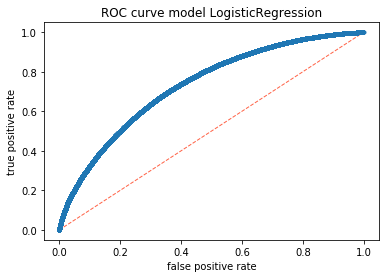

In [19]:
model_logit, y_pred_logit, \
logit_auc, logit_metrics = fx.metrics_model('logit_model.sav',
                                            X_train, y_train, X_test)



----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier
----------------------------------------------------------------------------
AUC:  0.6983533196835751
MATRIZ DE CONFUSION


,Verdadero,Falso
Verdadero,69947,42376
Falso,37250,75073


,0,1,accuracy,macro avg,weighted avg
precision,0.652509,0.639197,0.645549,0.645853,0.645853
recall,0.622731,0.668367,0.645549,0.645549,0.645549
f1-score,0.637272,0.653456,0.645549,0.645364,0.645364
support,112323.000000,112323.000000,0.645549,224646.000000,224646.000000


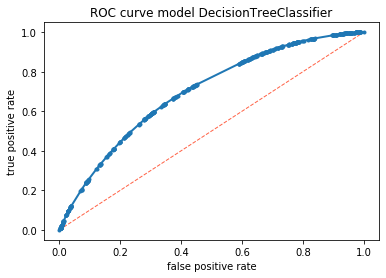

In [20]:
model_tree, y_pred_tree, \
tree_auc, tree_metrics = fx.metrics_model('dec_tree_model.sav',
                                          X_train, y_train, X_test)



----------------------------------------------------------------------------
Metrics Report Model GradientBoostingClassifier
----------------------------------------------------------------------------
AUC:  0.7399239696207092
MATRIZ DE CONFUSION


,Verdadero,Falso
Verdadero,74615,37708
Falso,35378,76945


,0,1,accuracy,macro avg,weighted avg
precision,0.678361,0.671112,0.674661,0.674737,0.674737
recall,0.664290,0.685033,0.674661,0.674661,0.674661
f1-score,0.671252,0.678001,0.674661,0.674626,0.674626
support,112323.000000,112323.000000,0.674661,224646.000000,224646.000000


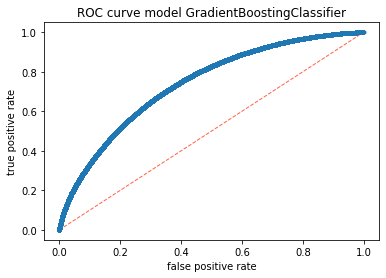

In [21]:
model_gradient, y_pred_gradient, \
gradient_auc, gradient_metrics = fx.metrics_model('gradient_model.sav',
                                                  X_train, y_train, X_test)



## Comparativa de Metricas de Rendimiento

Metrics Comparation


,Model_LogisticRegression,Model_DecisionTreeClassifier,Model_GradientBoostingClassifier
AUC,0.732742,0.698353,0.739924
Accuracy,0.670090,0.645550,0.674660
Presicion,0.670100,0.645850,0.674740
Recall,0.670090,0.645550,0.674660
F1,0.670080,0.645360,0.674630


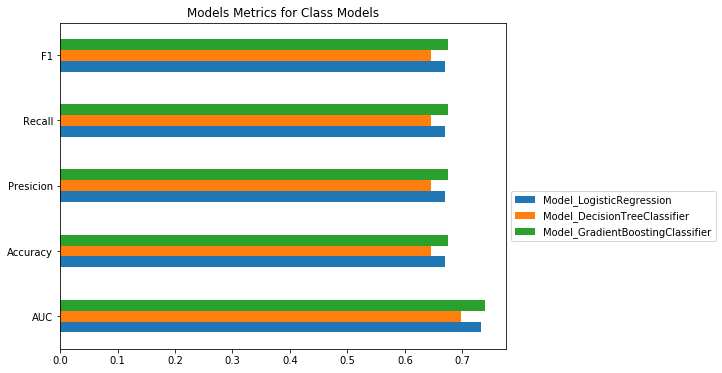

In [22]:
fx.metrics_comparative(model_list = [model_logit, model_tree, model_gradient],
                       auc_list = [logit_auc, tree_auc, gradient_auc],
                       metrics_list = [logit_metrics, tree_metrics, gradient_metrics],
                       y_train = y_train,
                       y_pred_list = [y_pred_logit, y_pred_tree, y_pred_gradient])

# Conclusiones

- Se puede observar que en general, los 3 modelos tienen un ajuste bastante competente (todos por sobre el 69% de AUC).  
- La exactitud y precisión de los modelos también es bastante parecida, esto queda evidenciado en las curvas ROC anteriormente mostradas.  
- Por lo anterior, el modelo con mejor rendimiento es Gradient Boostin Classifier ya que en todos los indicadores presenta mejores resultados que los otros 2 modelos.

In [24]:
def plot_importance(fit_model, feat_names):
    """
    Función para graficar importancia de las características.
    
    - fit_model: modelo ya entrenado a graficar
    - feat_names: características a considerar
    
    returns:
    Gráfico de barras, mostrando de forma ordenada la improtancia de las características.
    """
    if fit_model.__class__.__name__ == "LinearRegression":
        tmp_importance = fit_model.coef_
    else:
        tmp_importance = fit_model.feature_importances_
    
    importance_df = pd.DataFrame(tmp_importance, index=feat_names, columns=['value'])
    importance_df = importance_df.sort_values(by='value', ascending=False).head(10)
    plt.title('Feature importance de modelo {}' .format(fit_model.__class__.__name__))
    #importance_df['value'].plot.barh()
    importance_df['value'].plot(kind='bar', colormap = "tab20c") 

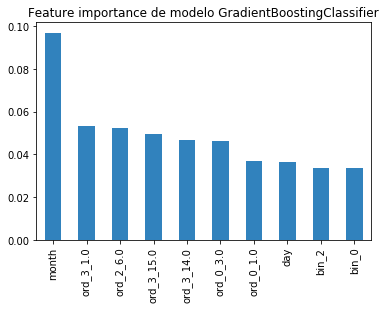

In [27]:
plot_importance(model_gradient, X_train.columns)

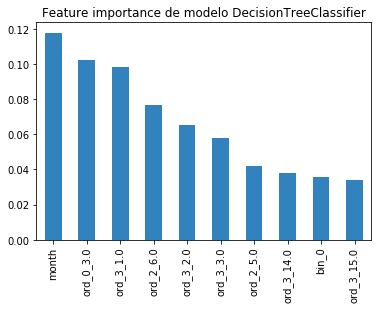

In [29]:
plot_importance(model_tree, X_train.columns)